In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 고정적 seed 42로 고정.
import os
import random
import numpy as np
import tensorflow as tf
import logging


SEED =42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=SEED, fast_n_close=False):
    """
        Enable 100% reproducibility on operations related to tensor and randomness.
        Parameters:
        seed (int): seed value for global randomness
        fast_n_close (bool): whether to achieve efficient at the cost of determinism/reproducibility
    """
    set_seeds(seed=seed)
    if fast_n_close:
        return

    logging.warning("*******************************************************************************")
    logging.warning("*** set_global_determinism is called,setting full determinism, will be slow ***")
    logging.warning("*******************************************************************************")

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
#     from tfdeterminism import patch
#     patch()    
    
set_seeds(42)
set_global_determinism(42)

In [3]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 설명
* TurbID - 발전기 ID
* Day - 날짜
* Tmstamp - 시간
* Wspd - 풍속
* Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
* Etmp - 외부 온도
* Itmp - 터빈 내부 온도
* Ndir - 터빈이 바라보는 방향 각도
* Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
* Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
* Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력 <br><br>

* <b>label: Patv </b>
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.

In [4]:
import pandas as p
import numpy as np
from tqdm import tqdm

In [5]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [6]:
pred_data = pd.read_csv("submission/0717_LSTM_Wspd_cv_test_1_92.csv")
location_data = pd.read_csv("data/turb_location.csv")
test_data = sample_submission.copy()

In [7]:
test_data['Wspd'] = pred_data['Wspd']

In [8]:
test_data

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,3.027515,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,3.507908,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,3.131422,0,0,0,0,0,0,0,0,9999
3,3,1,201,00:30,3.227306,0,0,0,0,0,0,0,0,9999
4,4,1,201,00:40,3.119351,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,6.174265,0,0,0,0,0,0,0,0,9999
38588,38588,134,202,23:20,6.196796,0,0,0,0,0,0,0,0,9999
38589,38589,134,202,23:30,5.307181,0,0,0,0,0,0,0,0,9999
38590,38590,134,202,23:40,5.167904,0,0,0,0,0,0,0,0,9999


In [9]:
df_updated = train_data.copy()

In [10]:
df_updated

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [11]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


# Timestamp 변환 (시간, 분)으로 변경
* hour, minute로 변환

In [12]:
df['Tmstamp'][0].split(':')

['00', '00']

In [13]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [14]:
print(int(a))

3


In [15]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))
test_data['hour'] = test_data['Tmstamp'].apply(lambda x: make_hour(x))

In [16]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))
test_data['minute'] = test_data['Tmstamp'].apply(lambda x: make_minute(x))

In [17]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(df["Tmstamp"]))

df["Tmstamp"] = df["Tmstamp"].apply(lambda x : tms_list.index(x))

In [18]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(test_data["Tmstamp"]))

test_data["Tmstamp"] = test_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [19]:
df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,hour,minute
0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,1,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0,1
2,1,1,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,0,2
3,1,1,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,0,3
4,1,1,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,23,1
3859196,134,200,140,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,23,2
3859197,134,200,141,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,23,3
3859198,134,200,142,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,23,4


In [20]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]
test_data = test_data[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [21]:
df.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [22]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [23]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


# hour, Day, TurbID, minute 순으로 재정렬.
* 이유는 hour과 Wspd의 관계를 봤을 때,
* 제시한 바와같이 정렬하게 될 시에, hour, Day, TurbID, minute 순으로 정렬이 된다.
* Wspd는 같은 hour이어야하기 때문에 hour이 먼저, 그 다음에 다른 TurbID의 값을 interpolate해줘야하기 때문에 Day, 그 다음 TurbID, minute 순으로 정렬

In [24]:
df = train_data.copy()

In [25]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [26]:
df[0:10]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
5,1,1,5,0,5,6.10,-1.03,30.47,41.22,20.91,1.00,1.00,1.00,-0.27,482.21
6,2,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2,1,1,0,1,6.85,-6.73,25.45,35.52,25.25,0.78,0.78,0.78,-0.16,449.83
8,2,1,2,0,2,7.02,-9.77,25.34,35.85,25.25,0.05,0.05,0.05,-0.19,449.67
9,2,1,3,0,3,7.26,-9.75,25.29,35.68,25.25,0.68,0.68,0.68,-0.14,474.48


In [27]:
df[100:120]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
100,17,1,4,0,4,5.10,-4.22,31.55,34.70,-164.29,0.05,0.05,0.05,-0.18,366.79
101,17,1,5,0,5,5.18,-4.31,31.47,34.60,-164.29,0.03,0.03,0.03,-0.21,349.17
102,18,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,18,1,1,0,1,6.26,-5.86,31.29,37.79,35.35,0.64,0.64,0.64,-0.04,375.78
104,18,1,2,0,2,6.10,-4.58,31.29,37.79,35.35,0.23,0.23,0.23,0.00,369.99
105,18,1,3,0,3,5.82,-6.76,31.17,37.79,35.35,0.25,0.25,0.25,-0.03,307.73
106,18,1,4,0,4,5.89,-7.52,31.09,37.79,35.30,0.04,0.04,0.04,0.01,324.62
107,18,1,5,0,5,5.81,-7.21,31.05,37.62,35.29,0.02,0.02,0.02,-0.01,304.66
108,19,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,19,1,1,0,1,5.28,-3.81,29.57,41.46,-62.67,0.95,0.95,0.95,-0.18,381.43


In [28]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [29]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

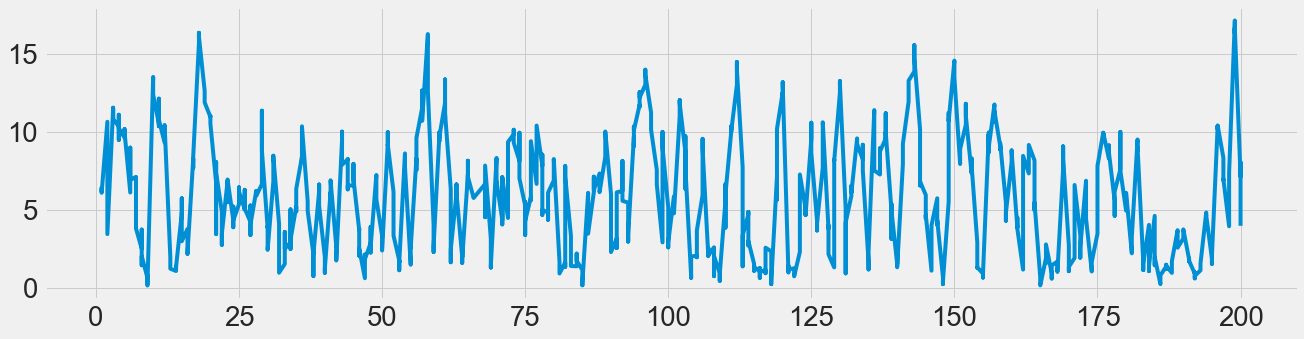

In [30]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [31]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


# 정렬한 것 원래대로 만들기.

In [32]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [33]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


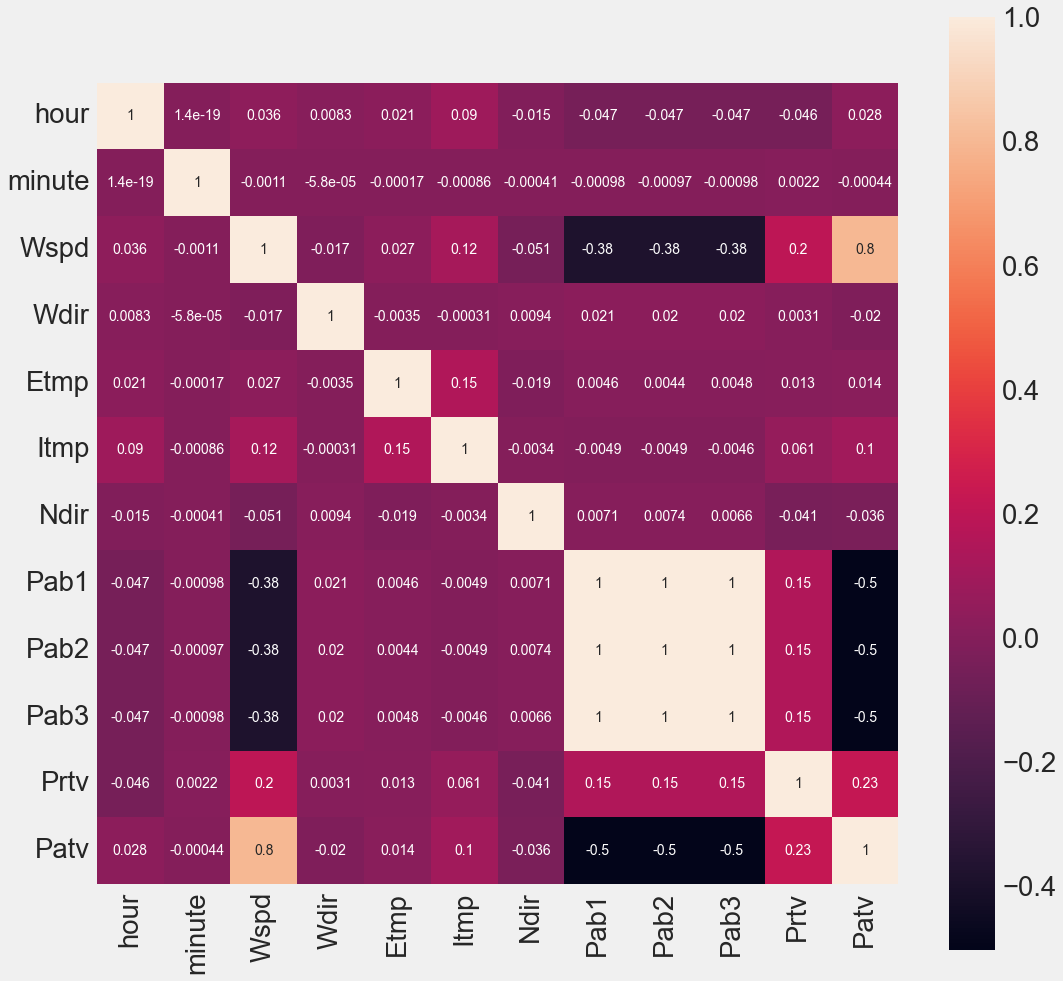

In [34]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data[['hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].corr(), annot=True, square=True)
plt.show()

In [35]:
train_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp',
       'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')

In [36]:
train_data.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

In [37]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


# test data에는 hour, Wspd로만 Patv 예측.

In [38]:
test_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,201,0,0,0,3.027515,0,0,0,0,0,0,0,0,9999
1,1,201,1,0,1,3.507908,0,0,0,0,0,0,0,0,9999
2,1,201,2,0,2,3.131422,0,0,0,0,0,0,0,0,9999
3,1,201,3,0,3,3.227306,0,0,0,0,0,0,0,0,9999
4,1,201,4,0,4,3.119351,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,139,23,1,6.174265,0,0,0,0,0,0,0,0,9999
38588,134,202,140,23,2,6.196796,0,0,0,0,0,0,0,0,9999
38589,134,202,141,23,3,5.307181,0,0,0,0,0,0,0,0,9999
38590,134,202,142,23,4,5.167904,0,0,0,0,0,0,0,0,9999


In [39]:
from datetime import datetime, timedelta

def get_date(k):
    cur_date = "2021-01-01"
    one_day = timedelta(days=k-1)
    return str(datetime.strptime(cur_date, '%Y-%m-%d') + one_day)[:10]

In [40]:
train_data['datetime'] = train_data['Day'].apply(lambda x: get_date(x))
test_data['datetime'] = test_data['Day'].apply(lambda x: get_date(x))

train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

In [41]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,datetime
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2021-01-01
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2021-01-01
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,2021-07-19
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,2021-07-19
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,2021-07-19
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,2021-07-19


In [42]:
test_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,datetime
0,1,201,0,0,0,3.027515,0,0,0,0,0,0,0,0,9999,2021-07-20
1,1,201,1,0,1,3.507908,0,0,0,0,0,0,0,0,9999,2021-07-20
2,1,201,2,0,2,3.131422,0,0,0,0,0,0,0,0,9999,2021-07-20
3,1,201,3,0,3,3.227306,0,0,0,0,0,0,0,0,9999,2021-07-20
4,1,201,4,0,4,3.119351,0,0,0,0,0,0,0,0,9999,2021-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,139,23,1,6.174265,0,0,0,0,0,0,0,0,9999,2021-07-21
38588,134,202,140,23,2,6.196796,0,0,0,0,0,0,0,0,9999,2021-07-21
38589,134,202,141,23,3,5.307181,0,0,0,0,0,0,0,0,9999,2021-07-21
38590,134,202,142,23,4,5.167904,0,0,0,0,0,0,0,0,9999,2021-07-21


In [43]:
# https://moondol-ai.tistory.com/180
def check_weekend(date):
    weekday = date.weekday()
    if weekday <= 4:
        return 0
    if weekday > 4:
        return 1


train_data['time_year'] = train_data['datetime'].dt.year
train_data['time_month'] = train_data['datetime'].dt.month
train_data['time_day'] = train_data['datetime'].dt.day
train_data['time_hour'] = train_data['datetime'].dt.hour
train_data['time_weekofyear'] = train_data['datetime'].dt.weekofyear
train_data['time_dayofweek'] = train_data['datetime'].dt.dayofweek

train_data['time_is_wknd'] = train_data['datetime'].apply(lambda x: check_weekend(x))
train_data['time_quarter'] = train_data['datetime'].dt.quarter

train_data['time_is_month_start'] = train_data['datetime'].dt.is_month_start
train_data['time_is_month_start'] = train_data['time_is_month_start'].astype(int)
train_data['time_is_month_end'] = train_data['datetime'].dt.is_quarter_end   
train_data['time_is_month_end'] = train_data['time_is_month_end'].astype(int)



test_data['time_year'] = test_data['datetime'].dt.year
test_data['time_month'] = test_data['datetime'].dt.month
test_data['time_day'] = test_data['datetime'].dt.day
test_data['time_hour'] = test_data['datetime'].dt.hour
test_data['time_weekofyear'] = test_data['datetime'].dt.weekofyear
test_data['time_dayofweek'] = test_data['datetime'].dt.dayofweek

test_data['time_is_wknd'] = test_data['datetime'].apply(lambda x: check_weekend(x))
test_data['time_quarter'] = test_data['datetime'].dt.quarter

test_data['time_is_month_start'] = test_data['datetime'].dt.is_month_start
test_data['time_is_month_start'] = test_data['time_is_month_start'].astype(int)
test_data['time_is_month_end'] = test_data['datetime'].dt.is_quarter_end   
test_data['time_is_month_end'] = test_data['time_is_month_end'].astype(int)

In [44]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_year,time_month,time_day,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,...,2021,1,1,0,53,4,0,1,1,0
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,2021,1,1,0,53,4,0,1,1,0
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,2021,1,1,0,53,4,0,1,1,0
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,2021,1,1,0,53,4,0,1,1,0
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,2021,1,1,0,53,4,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,...,2021,7,19,0,29,0,0,3,0,0
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,...,2021,7,19,0,29,0,0,3,0,0
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,...,2021,7,19,0,29,0,0,3,0,0
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,...,2021,7,19,0,29,0,0,3,0,0


In [45]:
test_data.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_year,time_month,time_day,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end
0,1,201,0,0,0,3.027515,0,0,0,0,...,2021,7,20,0,29,1,0,3,0,0
1,1,201,1,0,1,3.507908,0,0,0,0,...,2021,7,20,0,29,1,0,3,0,0
2,1,201,2,0,2,3.131422,0,0,0,0,...,2021,7,20,0,29,1,0,3,0,0
3,1,201,3,0,3,3.227306,0,0,0,0,...,2021,7,20,0,29,1,0,3,0,0
4,1,201,4,0,4,3.119351,0,0,0,0,...,2021,7,20,0,29,1,0,3,0,0


# location 합쳐주기

In [46]:
location_data

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175
...,...,...,...
129,130,12.6509,4814.60040
130,131,23.3458,5284.65439
131,132,62.6774,5749.90633
132,133,78.4309,6231.32903


In [47]:
def make_distance(x_values, y_values):
    return np.sqrt((x_values)**2 + (y_values)**2)

location_data['distance'] = location_data.apply(lambda x: make_distance(x['x'], x['y']), axis=1)

In [48]:
train_data = pd.merge(train_data, location_data, on='TurbID')
test_data = pd.merge(test_data, location_data, on='TurbID')

In [49]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end,x,y,distance
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745


In [50]:
test_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end,x,y,distance
0,1,201,0,0,0,3.027515,0,0,0,0,...,0,29,1,0,3,0,0,3349.8515,5939.23193,6818.796154
1,1,201,1,0,1,3.507908,0,0,0,0,...,0,29,1,0,3,0,0,3349.8515,5939.23193,6818.796154
2,1,201,2,0,2,3.131422,0,0,0,0,...,0,29,1,0,3,0,0,3349.8515,5939.23193,6818.796154
3,1,201,3,0,3,3.227306,0,0,0,0,...,0,29,1,0,3,0,0,3349.8515,5939.23193,6818.796154
4,1,201,4,0,4,3.119351,0,0,0,0,...,0,29,1,0,3,0,0,3349.8515,5939.23193,6818.796154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,139,23,1,6.174265,0,0,0,0,...,0,29,2,0,3,0,0,11.3385,6713.46517,6713.474745
38588,134,202,140,23,2,6.196796,0,0,0,0,...,0,29,2,0,3,0,0,11.3385,6713.46517,6713.474745
38589,134,202,141,23,3,5.307181,0,0,0,0,...,0,29,2,0,3,0,0,11.3385,6713.46517,6713.474745
38590,134,202,142,23,4,5.167904,0,0,0,0,...,0,29,2,0,3,0,0,11.3385,6713.46517,6713.474745


# 그 날의 풍속의 평균 _mean, std, var, max, min 등의 column들 생성.
* 터빈별 풍속 mean, std, var, max, min
* Day별 풍속, mean, std, var, max, min
* 터빈, Day별 풍속 mean, std, var, max, min

In [51]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end,x,y,distance
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,0,53,4,0,1,1,0,3349.8515,5939.23193,6818.796154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,...,0,29,0,0,3,0,0,11.3385,6713.46517,6713.474745


In [52]:
# 터빈별 mean, std, var, max, min
for i in tqdm(range(1, 135)):
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_mean'] = train_data[train_data['TurbID']==i]['Wspd'].mean()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_std'] = train_data[train_data['TurbID']==i]['Wspd'].std()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_var'] = train_data[train_data['TurbID']==i]['Wspd'].var()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_max'] = train_data[train_data['TurbID']==i]['Wspd'].max()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_min'] = train_data[train_data['TurbID']==i]['Wspd'].min()
    
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_mean'] = test_data[test_data['TurbID']==i]['Wspd'].mean()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_std'] = test_data[test_data['TurbID']==i]['Wspd'].std()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_var'] = test_data[test_data['TurbID']==i]['Wspd'].var()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_max'] = test_data[test_data['TurbID']==i]['Wspd'].max()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_min'] = test_data[test_data['TurbID']==i]['Wspd'].min()
    
# Day 별 풍속 mean, std, var, max, min
for i in tqdm(range(1, 201)): # 1~ 200일
    train_data.loc[train_data['Day']==i, 'Day_Wspd_mean'] = train_data[train_data['Day']==i]['Wspd'].mean()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_std'] = train_data[train_data['Day']==i]['Wspd'].std()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_var'] = train_data[train_data['Day']==i]['Wspd'].var()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_max'] = train_data[train_data['Day']==i]['Wspd'].max()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_min'] = train_data[train_data['Day']==i]['Wspd'].min()

for i in tqdm(range(201, 203)):     # 201~202일
    test_data.loc[test_data['Day']==i, 'Day_Wspd_mean'] = test_data[test_data['Day']==i]['Wspd'].mean()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_std'] = test_data[test_data['Day']==i]['Wspd'].std()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_var'] = test_data[test_data['Day']==i]['Wspd'].var()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_max'] = test_data[test_data['Day']==i]['Wspd'].max()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_min'] = test_data[test_data['Day']==i]['Wspd'].min()
    
# for i in tqdm(range(1, 135)):
#     for j in range(1, 201):
#         train_data.loc[(train_data['TurbID']==i) & (train_data['Day']==j), 'Turbin_Day_Wspd_mean'] = train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'].mean()
#         train_data.loc[(train_data['TurbID']==i) & (train_data['Day']==j), 'Turbin_Day_Wspd_std'] = train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'].std()
#         train_data.loc[(train_data['TurbID']==i) & (train_data['Day']==j), 'Turbin_Day_Wspd_var'] = train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'].var()
#         train_data.loc[(train_data['TurbID']==i) & (train_data['Day']==j), 'Turbin_Day_Wspd_max'] = train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'].max()
#         train_data.loc[(train_data['TurbID']==i) & (train_data['Day']==j), 'Turbin_Day_Wspd_min'] = train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'].min()
    
#         test_data.loc[(test_data['TurbID']==i) & (test_data['Day']==j), 'Turbin_Day_Wspd_mean'] = test_data[(test_data['TurbID']==i) & (test_data['Day']==j)]['Wspd'].mean()
#         test_data.loc[(test_data['TurbID']==i) & (test_data['Day']==j), 'Turbin_Day_Wspd_std'] = test_data[(test_data['TurbID']==i) & (test_data['Day']==j)]['Wspd'].std()
#         test_data.loc[(test_data['TurbID']==i) & (test_data['Day']==j), 'Turbin_Day_Wspd_var'] = test_data[(test_data['TurbID']==i) & (test_data['Day']==j)]['Wspd'].var()
#         test_data.loc[(test_data['TurbID']==i) & (test_data['Day']==j), 'Turbin_Day_Wspd_max'] = test_data[(test_data['TurbID']==i) & (test_data['Day']==j)]['Wspd'].max()
#         test_data.loc[(test_data['TurbID']==i) & (test_data['Day']==j), 'Turbin_Day_Wspd_min'] = test_data[(test_data['TurbID']==i) & (test_data['Day']==j)]['Wspd'].min()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 57.30it/s]


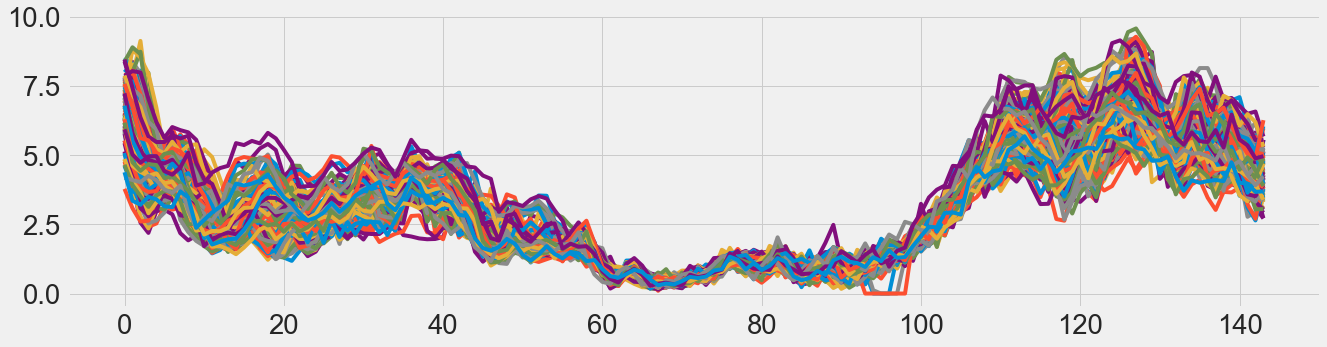

In [53]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 200 # Day
for i in range(1, 134): # TurbID / group 6
    plt.plot(train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Tmstamp'], train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [54]:
train_data.drop(columns=['datetime'], inplace=True)

In [55]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3859200 entries, 0 to 3859199
Data columns (total 38 columns):
 #   Column               Dtype  
---  ------               -----  
 0   TurbID               int64  
 1   Day                  int64  
 2   Tmstamp              int64  
 3   hour                 int64  
 4   minute               int64  
 5   Wspd                 float64
 6   Wdir                 float64
 7   Etmp                 float64
 8   Itmp                 float64
 9   Ndir                 float64
 10  Pab1                 float64
 11  Pab2                 float64
 12  Pab3                 float64
 13  Prtv                 float64
 14  Patv                 float64
 15  time_year            int64  
 16  time_month           int64  
 17  time_day             int64  
 18  time_hour            int64  
 19  time_weekofyear      int64  
 20  time_dayofweek       int64  
 21  time_is_wknd         int64  
 22  time_quarter         int64  
 23  time_is_month_start  int32  
 24

In [56]:
asdfasdfasdf

NameError: name 'asdfasdfasdf' is not defined

In [57]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,Turbin_Wspd_mean,Turbin_Wspd_std,Turbin_Wspd_var,Turbin_Wspd_max,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_std,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0


In [58]:
test_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,Turbin_Wspd_mean,Turbin_Wspd_std,Turbin_Wspd_var,Turbin_Wspd_max,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_std,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min
0,1,201,0,0,0,3.027515,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,3.363971,0.820916,0.673903,5.015013,1.111927
1,1,201,1,0,1,3.507908,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,3.363971,0.820916,0.673903,5.015013,1.111927
2,1,201,2,0,2,3.131422,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,3.363971,0.820916,0.673903,5.015013,1.111927
3,1,201,3,0,3,3.227306,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,3.363971,0.820916,0.673903,5.015013,1.111927
4,1,201,4,0,4,3.119351,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,3.363971,0.820916,0.673903,5.015013,1.111927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,139,23,1,6.174265,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,5.684526,0.923605,0.853046,7.529604,3.990016
38588,134,202,140,23,2,6.196796,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,5.684526,0.923605,0.853046,7.529604,3.990016
38589,134,202,141,23,3,5.307181,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,5.684526,0.923605,0.853046,7.529604,3.990016
38590,134,202,142,23,4,5.167904,0,0,0,0,...,4.524249,1.455002,2.11703,7.529604,1.111927,5.684526,0.923605,0.853046,7.529604,3.990016


# 쪼개기
* train data: 1~198일
* valid data: 199, 200일

In [59]:
f1 = (train_data['Day']==199) | (train_data['Day']==200)
valid_data = train_data.loc[f1]
valid_data.reset_index(drop=True, inplace=True)
valid_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,Turbin_Wspd_mean,Turbin_Wspd_std,Turbin_Wspd_var,Turbin_Wspd_max,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_std,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min
0,1,199,0,0,0,17.12,3.78,12.90,29.40,11.65,...,5.590613,3.627709,13.160270,23.20,0.0,11.559920,4.867020,23.687881,22.30,0.0
1,1,199,1,0,1,16.52,6.32,12.87,29.40,11.69,...,5.590613,3.627709,13.160270,23.20,0.0,11.559920,4.867020,23.687881,22.30,0.0
2,1,199,2,0,2,16.37,4.51,12.93,29.40,15.82,...,5.590613,3.627709,13.160270,23.20,0.0,11.559920,4.867020,23.687881,22.30,0.0
3,1,199,3,0,3,16.29,-5.18,13.15,29.37,22.58,...,5.590613,3.627709,13.160270,23.20,0.0,11.559920,4.867020,23.687881,22.30,0.0
4,1,199,4,0,4,16.34,-4.75,13.11,29.37,22.83,...,5.590613,3.627709,13.160270,23.20,0.0,11.559920,4.867020,23.687881,22.30,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0
38588,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0
38589,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0
38590,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,...,5.193466,3.339119,11.149714,19.81,0.0,3.087737,1.967272,3.870160,9.57,0.0


In [60]:
df = train_data.copy()

In [61]:
f2 = df[(df['Day']==199) | (df['Day']==200)].index
df.drop(index=f2, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,Turbin_Wspd_mean,Turbin_Wspd_std,Turbin_Wspd_var,Turbin_Wspd_max,Turbin_Wspd_min,Day_Wspd_mean,Day_Wspd_std,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,5.590613,3.627709,13.160270,23.20,0.0,7.318797,2.860979,8.185199,15.97,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820603,134,198,139,23,1,14.55,1.29,17.59,17.43,-13.74,...,5.193466,3.339119,11.149714,19.81,0.0,9.126608,3.306686,10.934173,18.95,0.0
3820604,134,198,140,23,2,15.08,0.98,17.57,17.40,-13.76,...,5.193466,3.339119,11.149714,19.81,0.0,9.126608,3.306686,10.934173,18.95,0.0
3820605,134,198,141,23,3,15.71,2.07,17.49,17.40,-13.76,...,5.193466,3.339119,11.149714,19.81,0.0,9.126608,3.306686,10.934173,18.95,0.0
3820606,134,198,142,23,4,16.24,3.43,17.33,17.40,-13.76,...,5.193466,3.339119,11.149714,19.81,0.0,9.126608,3.306686,10.934173,18.95,0.0


In [62]:
df.columns

Index(['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp',
       'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv', 'time_year',
       'time_month', 'time_day', 'time_hour', 'time_weekofyear',
       'time_dayofweek', 'time_is_wknd', 'time_quarter', 'time_is_month_start',
       'time_is_month_end', 'x', 'y', 'distance', 'Turbin_Wspd_mean',
       'Turbin_Wspd_std', 'Turbin_Wspd_var', 'Turbin_Wspd_max',
       'Turbin_Wspd_min', 'Day_Wspd_mean', 'Day_Wspd_std', 'Day_Wspd_var',
       'Day_Wspd_max', 'Day_Wspd_min'],
      dtype='object')

# 데이터 나누기

In [63]:
df_columns = ['TurbID', 'Day', 'Tmstamp', 'Wspd', 'time_year', 'time_month', 'time_day', 'time_hour', 'time_weekofyear',
       'time_dayofweek', 'time_is_wknd', 'time_quarter', 'time_is_month_start',
       'time_is_month_end', 'x', 'y', 'distance', 'Turbin_Wspd_mean',
       'Turbin_Wspd_std', 'Turbin_Wspd_var', 'Turbin_Wspd_max',
       'Turbin_Wspd_min', 'Day_Wspd_mean', 'Day_Wspd_std', 'Day_Wspd_var',
       'Day_Wspd_max', 'Day_Wspd_min']

print(len(df_columns))

X_train, y_train = df.loc[:, df_columns], df.loc[:, ['Patv']]
X_valid, y_valid = valid_data.loc[:, df_columns], valid_data.loc[:, ['Patv']]

X_test = test_data[df_columns]

27


In [64]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape)

(3820608, 27) (3820608, 1)
(38592, 27) (38592, 1)
(38592, 27)


# 표준화 및 정규화

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.datasets import load_iris
import pandas as pd

scaler = StandardScaler()
scaler.fit(X_train)
X_train_standardScaled = scaler.transform(X_train)
X_valid_standardScaled = scaler.transform(X_valid)
X_test_standardScaled = scaler.transform(X_test)

# model: XGBoost

In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [67]:
from sklearn.metrics import mean_squared_error #필요한 라이브러리 불러오기
from sklearn.metrics import mean_absolute_error

def RMSE_MAE(y_true, y_pred):
    mse1 = np.mean(np.square((y_true - y_pred)))
    mae1 = np.mean(np.abs((y_true - y_pred)))
    
    return (np.sqrt(mse1) + mae1) / 2

In [68]:
xgb_reg = XGBRegressor(n_estimators = 80)

In [69]:
xgb_reg.fit(X_train_standardScaled, y_train, eval_set=[(X_train_standardScaled, y_train), (X_valid_standardScaled, y_valid)], early_stopping_rounds=300,
            verbose=False)

[00:21:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=90)

In [70]:
pred = xgb_reg.predict(X_valid_standardScaled)

In [71]:
pred

array([1210.6898 , 1210.6898 , 1210.6898 , ...,  189.66891,  204.10239,
        249.13086], dtype=float32)

In [72]:
y_valid = np.array(y_valid).reshape(1, -1)

In [73]:
# from sktime.utils.plotting import plot_series
# pred = pd.Series(pred)
# pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('RMSE_MAE : {}'.format(RMSE_MAE(y_valid, pred)))

best iterations: 64
RMSE_MAE : 259.2136087468922


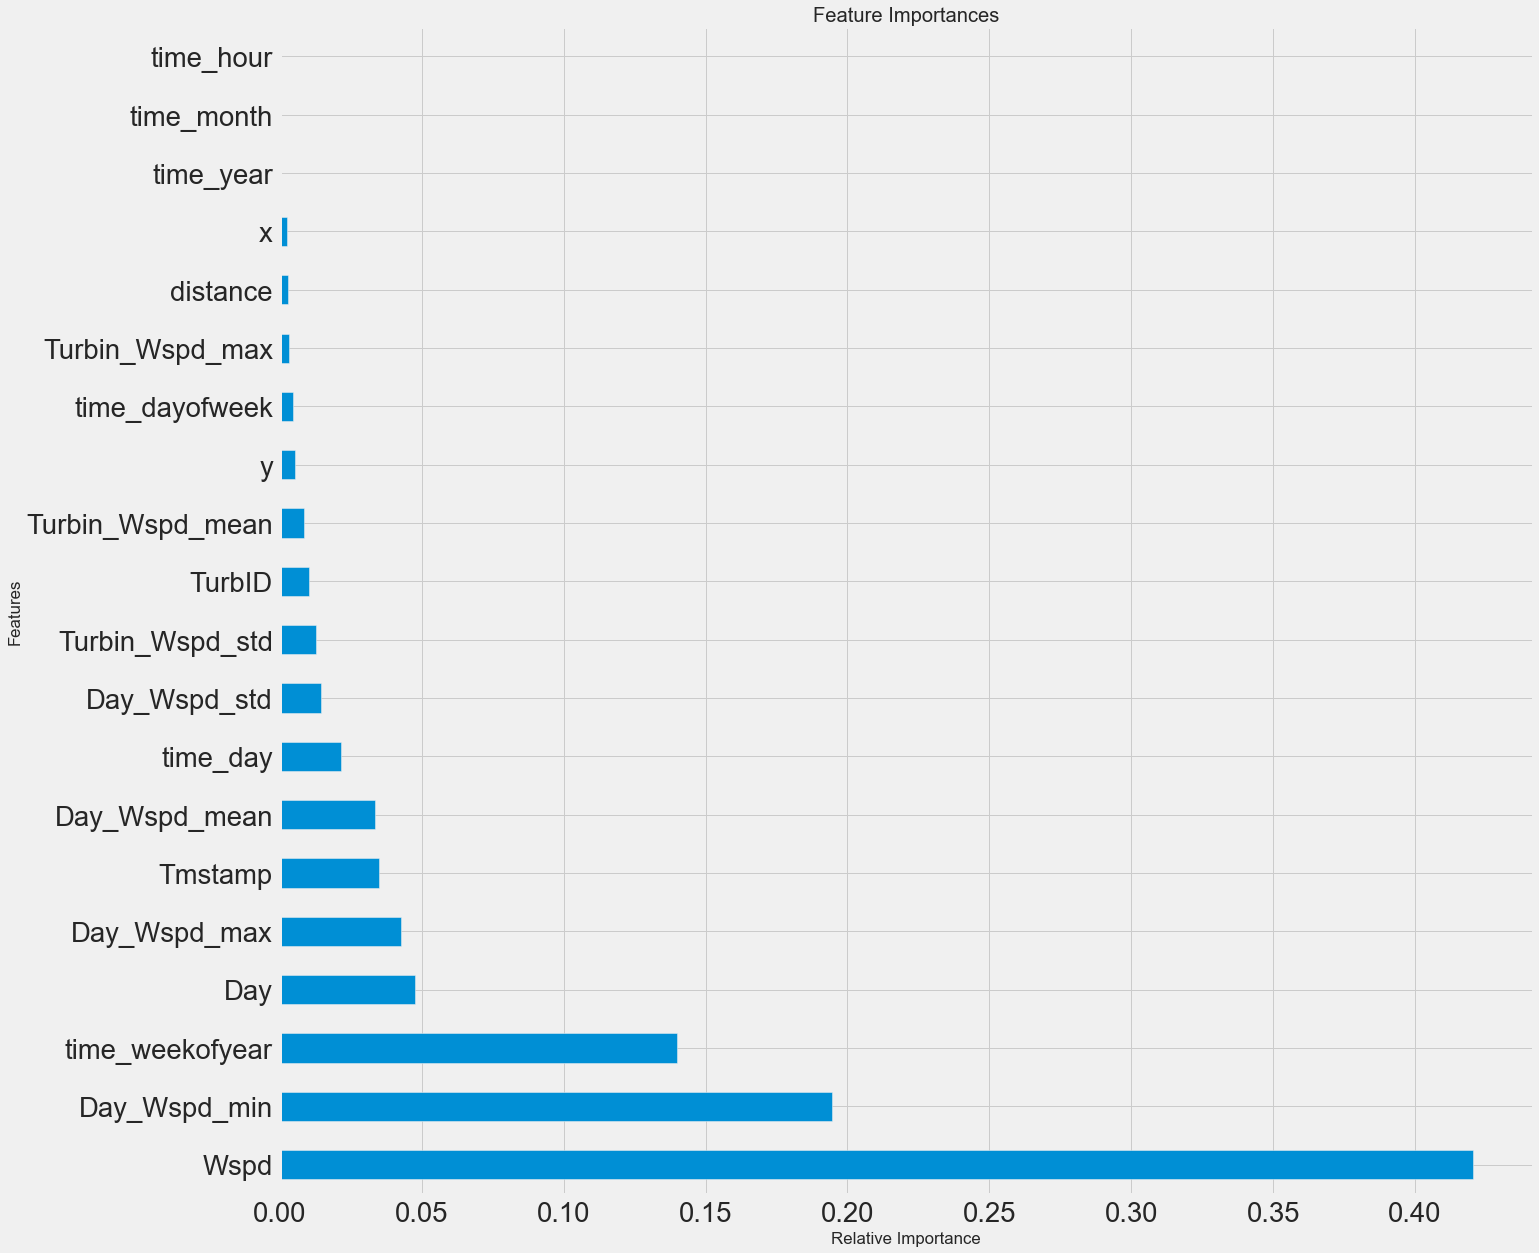

In [74]:
# Feature importance for xgboost
plt.figure(figsize=(20, 20))
feat_importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [ ]:
asdfasdfasd

In [75]:
# X_test

In [76]:
X_test_standardScaled

array([[-1.71917293,  1.77581211, -1.72006415, ..., -1.18209839,
        -2.07950658,  1.71152916],
       [-1.71917293,  1.77581211, -1.69600731, ..., -1.18209839,
        -2.07950658,  1.71152916],
       [-1.71917293,  1.77581211, -1.67195047, ..., -1.18209839,
        -2.07950658,  1.71152916],
       ...,
       [ 1.71917293,  1.7933078 ,  1.67195047, ..., -1.13995988,
        -1.44247068,  6.57194711],
       [ 1.71917293,  1.7933078 ,  1.69600731, ..., -1.13995988,
        -1.44247068,  6.57194711],
       [ 1.71917293,  1.7933078 ,  1.72006415, ..., -1.13995988,
        -1.44247068,  6.57194711]])

In [77]:
pred = xgb_reg.predict(X_test_standardScaled)

In [78]:
pred

array([ 89.63866 , 130.01747 ,  99.523705, ..., 393.48956 , 374.03464 ,
       462.08725 ], dtype=float32)

In [79]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,0,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,0,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,0,0,0,0,0,0,0,0,0,9999
3,3,1,201,00:30,0,0,0,0,0,0,0,0,0,9999
4,4,1,201,00:40,0,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,0,0,0,0,0,0,0,0,0,9999
38588,38588,134,202,23:20,0,0,0,0,0,0,0,0,0,9999
38589,38589,134,202,23:30,0,0,0,0,0,0,0,0,0,9999
38590,38590,134,202,23:40,0,0,0,0,0,0,0,0,0,9999


In [ ]:
sdafasdfasdf

In [80]:
sample_submission['Patv'] = pred

sample_submission.to_csv('0717_xgboost14.csv', index=False)